### 时序问题本质上是回归问题

## 传统时序建模

arima 模型是 arma 模型的升级版；arma 模型只能针对平稳数据进行建模，而 arima 模型需要先对数据进行差分，差分平稳后在进行建模。这两个模型能处理的问题还是比较简单，究其原因主要是以下两点：

- arma/arima 模型归根到底还是简单的线性模型，能表征的问题复杂程度有限；

- arma 全名是自回归滑动平均模型，它只能支持对单变量历史数据的回归，处理不了多变量的情况。

### 原理篇：
#### 基本的金融时间序列知识 
重点介绍基本的金融时间序列知识和 arma 模型:
https://zhuanlan.zhihu.com/p/38320827

更为高阶的 arch 和 garch 模型:
https://zhuanlan.zhihu.com/p/21962996

- arma模型实践

In [2]:
import pandas as pd
import numpy as np
from scipy import  stats
import matplotlib.pyplot as plt
import tushare as ts
import datetime
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

In [16]:
# pro = ts.pro_api('3001fe98f65a158f337ac7b0aa45c911c57973159023bd4bcbed2fd9')
# ALL_DATA=pro.cn_gdp()

gdp_data = pd.read_csv('C:/Users/Lenovo/Downloads/gdp.csv',encoding='gbk')
gdp_data['year'] = gdp_data['季度'].apply(lambda x:str(x)[:4])
gdp_data['实际GDP'] = gdp_data['实际GDP'].apply(lambda x:float(x.replace(',','')))

In [24]:
gdp_data_year = gdp_data.groupby(['year'],as_index=False).sum()[['year','实际GDP']]
gdp_data_year = gdp_data_year.rename(columns={'实际GDP':'GDP'})
gdp_data_year

In [30]:
gdp_data_year = gdp_data_year.set_index('year')
gdp_series = gdp_data_year['GDP']
gdp_series

,year,GDP
0,1948,8079.9
1,1949,8035.8
2,1950,8736.0
3,1951,9439.9
4,1952,9824.5
...,...,...
62,2010,59135.2
63,2011,60082.3
64,2012,61476.7
65,2013,62841.1


In [34]:
dftest = adfuller(gdp_series, autolag='AIC')
dftest

(1.8404645366781154,
 0.9984259839819806,
 1,
 65,
 {'1%': -3.5352168748293127,
  '5%': -2.9071540828402367,
  '10%': -2.5911025443786984},
 872.4317205460368)

In [35]:
def test_stationarity(timeseries):
    
    #滑动均值和方差
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #绘制滑动统计量
    plt.figure(figsize=(24, 8))   
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #adf检验，若t值小于Critical Value，则平稳（也可以参考p值）
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

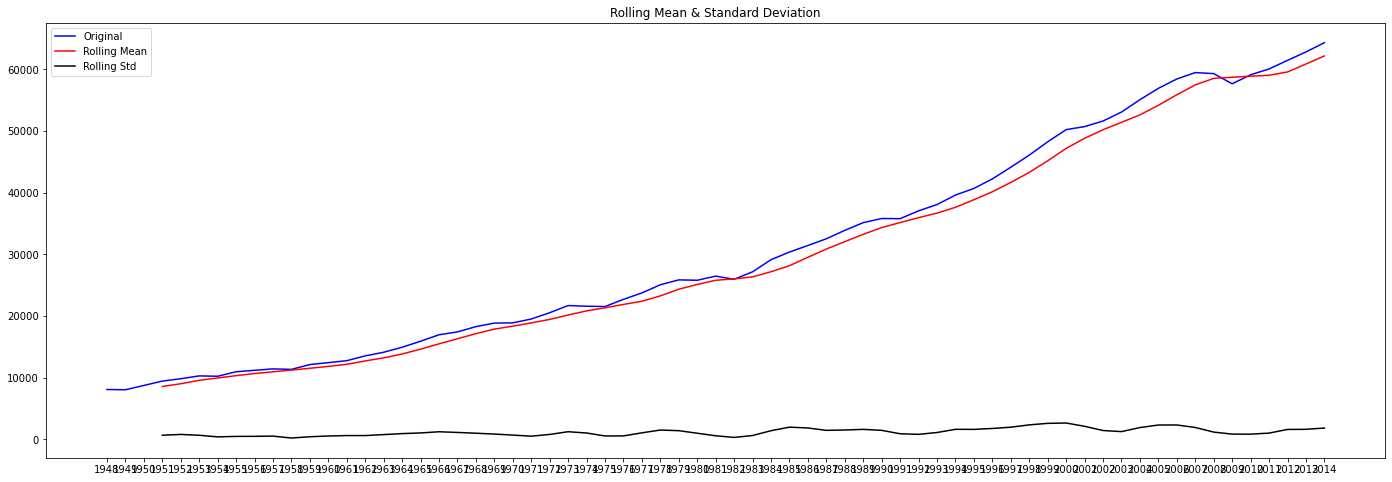

Results of Dickey-Fuller Test:
Test Statistic                  1.840465
p-value                         0.998426
#Lags Used                      1.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


In [37]:
test_stationarity(gdp_series)

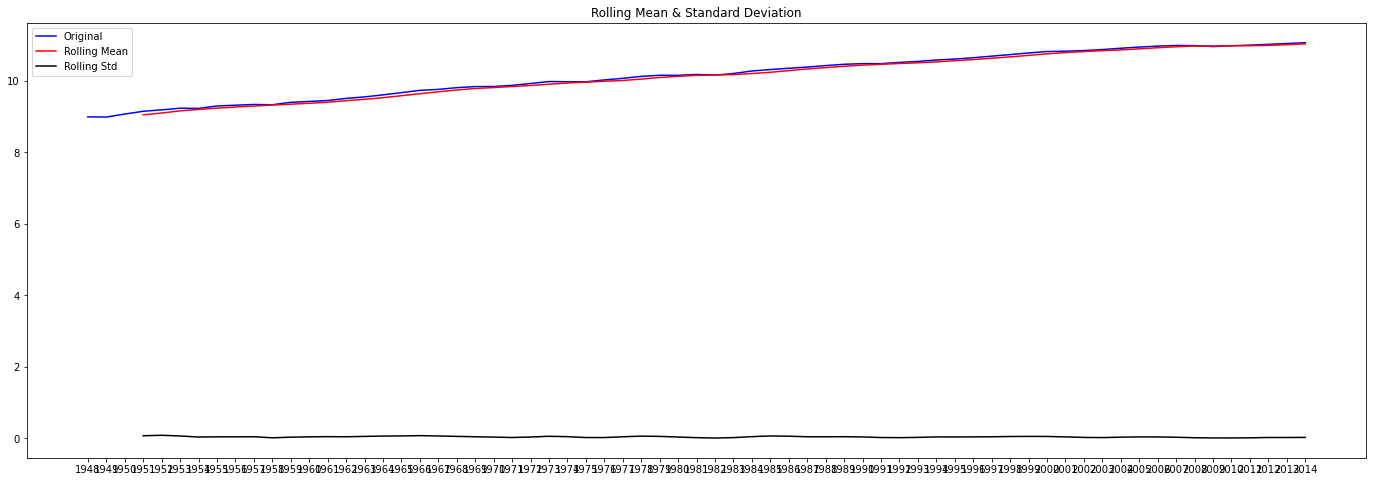

Results of Dickey-Fuller Test:
Test Statistic                 -2.690174
p-value                         0.075754
#Lags Used                      1.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


In [38]:
GDP_LOG = np.log(gdp_series)
test_stationarity(GDP_LOG)

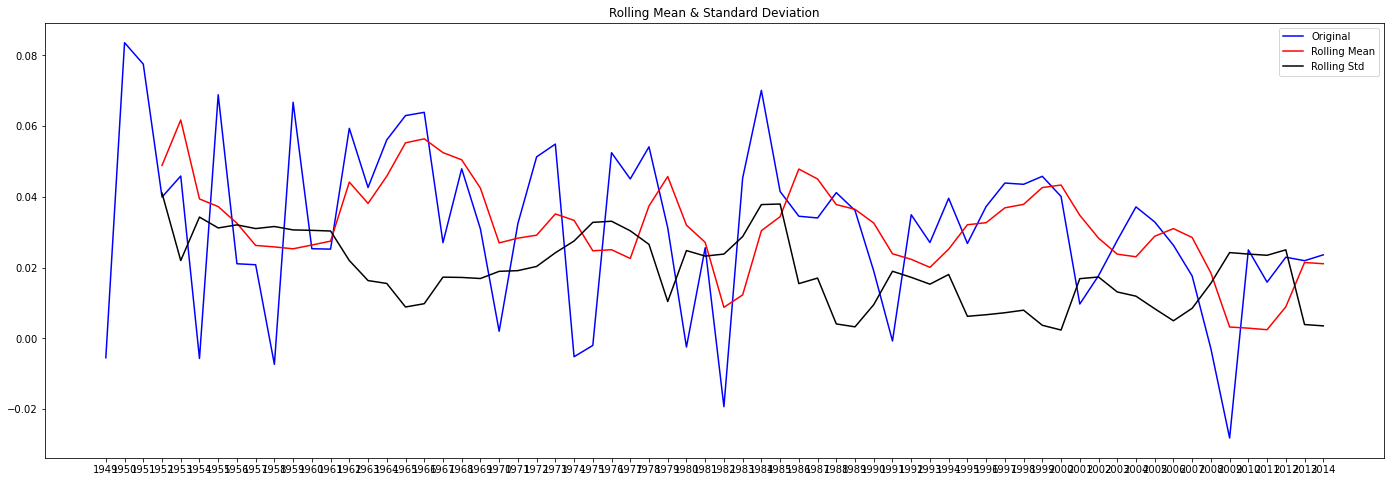

Results of Dickey-Fuller Test:
Test Statistic                -6.948839e+00
p-value                        9.811576e-10
#Lags Used                     0.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (1%)           -3.535217e+00
Critical Value (5%)           -2.907154e+00
Critical Value (10%)          -2.591103e+00
dtype: float64


In [39]:
#一阶差分
GDP_LOG_DIFF1=GDP_LOG.diff(1)
GDP_LOG_DIFF1.dropna(inplace=True)
test_stationarity(GDP_LOG_DIFF1)

In [40]:
GDP_LOG_DIFF1.index

Index(['1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957',
       '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966',
       '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975',
       '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014'],
      dtype='object', name='year')

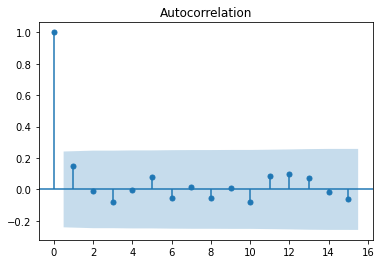

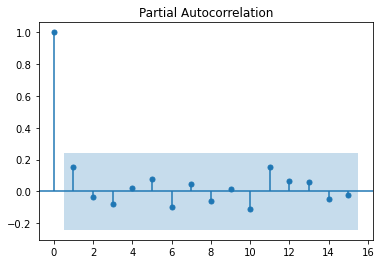

In [41]:
plot_acf(GDP_LOG_DIFF1,lags=15)
plot_pacf(GDP_LOG_DIFF1,lags=15)
plt.show()

In [42]:
#暴力定阶法
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(GDP_LOG_DIFF1,max_ar=3,max_ma=3,ic=['aic', 'bic', 'hqic'])
order.bic_min_order

E:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
E:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated i

(0, 0)

In [117]:
MODEL20=ARMA(GDP_LOG_DIFF1,(0,1)).fit()

E:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
E:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings

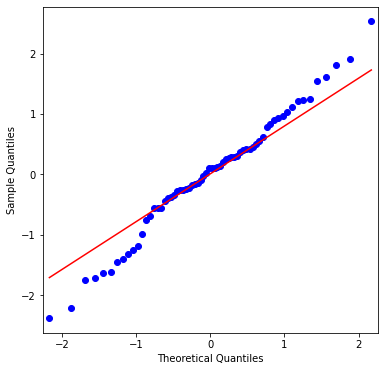

In [118]:
#白噪声检验
# 1.绘制白噪声序列的qq图
resid = MODEL20.resid
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [119]:
# 2.检验残差序列相关性
# 检验自相关常用的Durbin-Watson检验（D-W检验），DW值应在2左右
import statsmodels.api as sm
print(sm.stats.durbin_watson(resid.values))

1.9699267555869067


In [120]:
PREDICT_ARMA = MODEL20.predict(start=0,end=70)
PREDICT_ARMA.index = PREDICT_ARMA.index.year.astype('str')
PREDICT_ARMA.index.name = 'year'

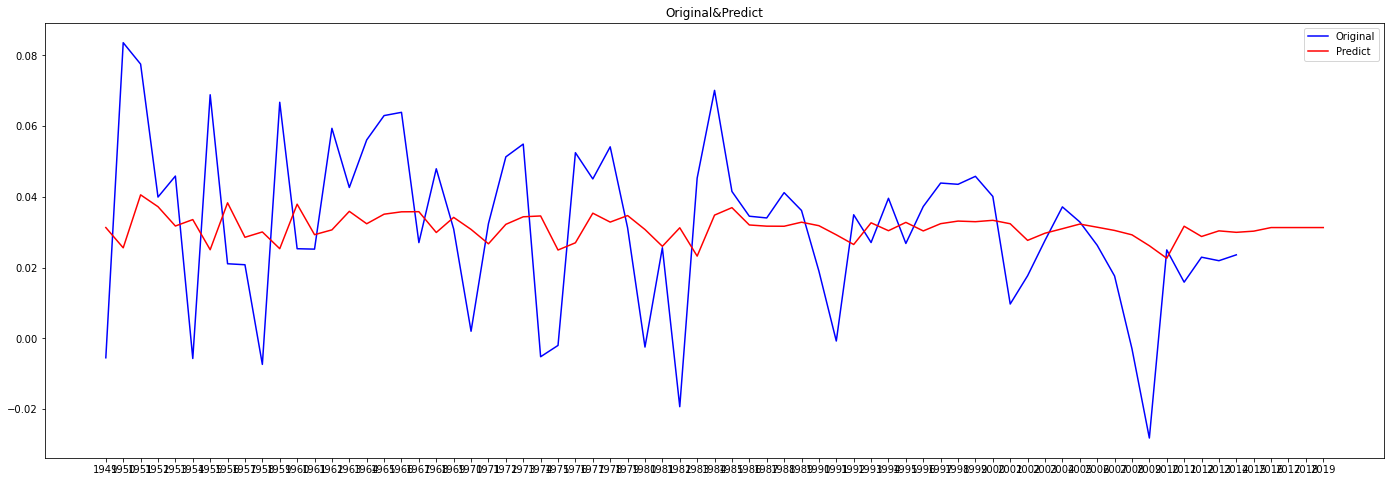

In [121]:
plt.figure(figsize=(24, 8))   
# GDP_LOG_DIFF1.index = GDP_LOG_DIFF1.index.astype()
orig = plt.plot(GDP_LOG_DIFF1, color='blue',label='Original')
predict = plt.plot(PREDICT_ARMA, color='red',label='Predict')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show(block=False)

In [102]:
GDP_LOG.index

Index(['1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956',
       '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014'],
      dtype='object', name='year')

In [106]:
# 一阶差分还原
PREDICT_GDP_LOG = PREDICT_ARMA.add(GDP_LOG.shift(1))
PREDICT_GDP_LOG['2015']=PREDICT_ARMA['2015']+GDP_LOG['2014']
# 对数还原
PREDICT_GDP = np.exp(PREDICT_GDP_LOG)
PREDICT_GDP.dropna(inplace=True)

In [108]:
PREDICT_GDP

year
1949     8336.873160
1950     8242.571038
1951     9095.574458
1952     9806.165135
1953    10144.636196
            ...     
2011    61004.386764
2012    61841.832341
2013    63359.023109
2014    64748.449706
2015    66314.159788
Length: 67, dtype: float64

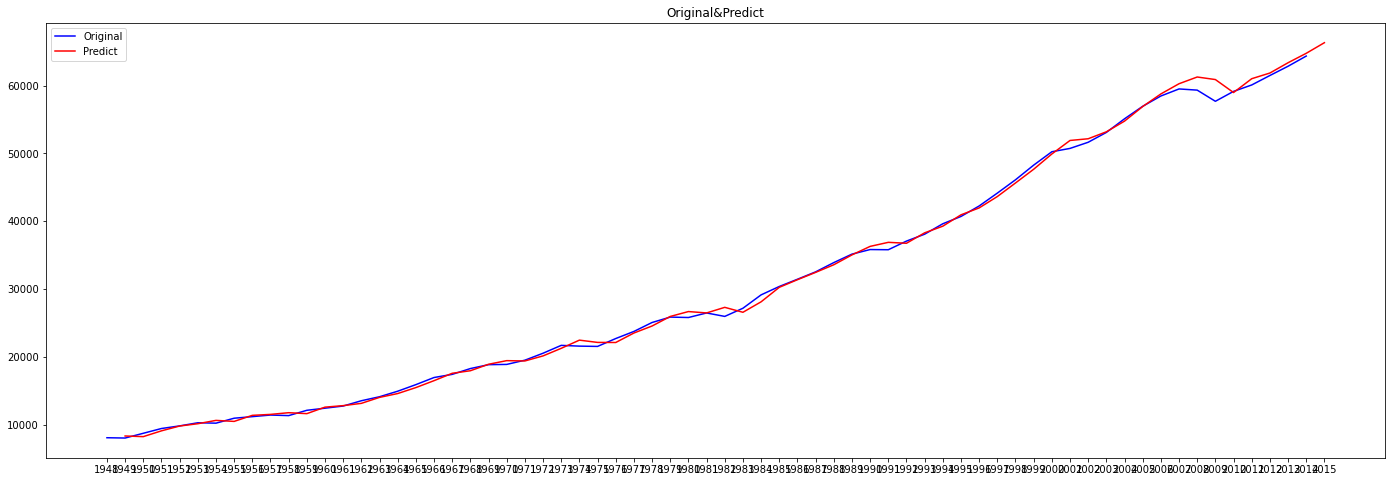

In [110]:
plt.figure(figsize=(24, 8))   
orig = plt.plot(gdp_series, color='blue',label='Original')
predict = plt.plot(PREDICT_GDP, color='red',label='Predict')
plt.legend(loc='best')
plt.title('Original&Predict')
plt.show(block=False)

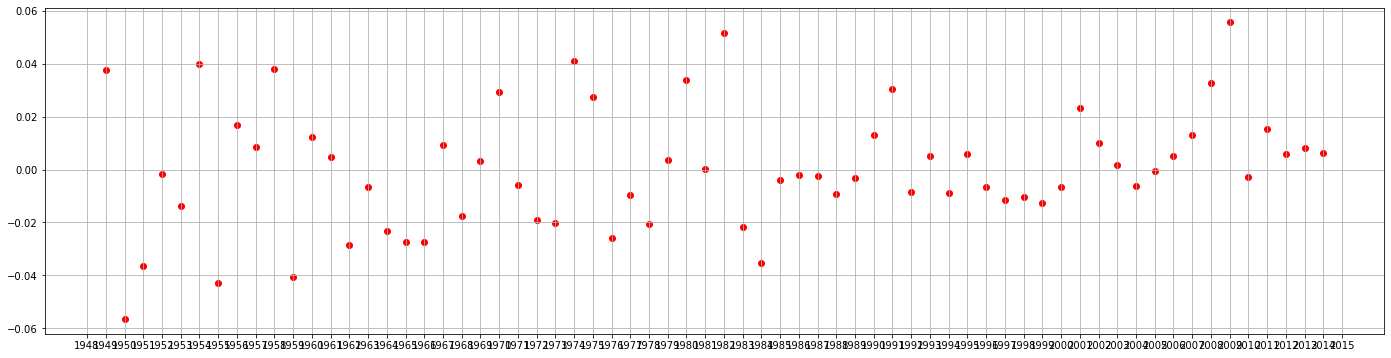

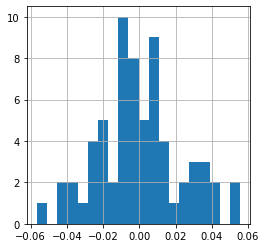

In [111]:
ERROR_RATE=(PREDICT_GDP-gdp_series)/gdp_series
plt.figure(figsize=(24, 6))   
plt.scatter(ERROR_RATE.index,ERROR_RATE,color='r')
plt.grid(True)
plt.figure(figsize=(4, 4))
plt.hist(ERROR_RATE, bins=20)
plt.grid(True)
plt.show()